In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/econ_515/model

/content/gdrive/MyDrive/econ_515/model


In [4]:
!pip install --upgrade xlrd
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 2.9 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np
import pandas as pd
import xlrd
from torchinfo import summary
import argparse
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from torchvision import transforms
import numpy as np
from datetime import date
import datetime
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from torch import nn
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import psycopg2


In [7]:
## read_excel
Natural_Gas = pd.read_excel('../data/gas_price.xls', sheet_name='Data 1', header=2, index_col=0)
Crude_Oil = pd.read_excel('../data/price_for_variables.xls', sheet_name='Data 1', header=2, index_col=0)
Heating_Oil = pd.read_excel('../data/price_for_variables.xls', sheet_name='Data 4', header=2, index_col=0)
Drilling = pd.read_excel('../data/drilling.xls', sheet_name='Data 3', header=2, index_col=0)

Production = pd.read_excel('../data/data.xls', sheet_name='Data 2', header=2, index_col=0)
Imports_Exports = pd.read_excel('../data/data.xls', sheet_name='Data 3', header=2, index_col=0)
Underground_Storage = pd.read_excel('../data/data.xls', sheet_name='Data 4', header=2, index_col=0)
Consumption = pd.read_excel('../data/data.xls', sheet_name='Data 5', header=2, index_col=0)


In [8]:
## get variables
start_date = '2001-01-15'
end_date = '2022-07-15'
Natural_Gas_Price = Natural_Gas.loc[start_date: end_date, 'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)']
Crude_Oil_Price = Crude_Oil.loc[start_date: end_date, 'Cushing, OK WTI Spot Price FOB (Dollars per Barrel)']
Heating_Oil_Price = Heating_Oil.loc[start_date: end_date, 'New York Harbor No. 2 Heating Oil Spot Price FOB (Dollars per Gallon)']
Drilling_activity = Drilling.loc[start_date: end_date, 'U.S. Natural Gas Rotary Rigs in Operation (Count)']

Natural_Gas_Supply = Production.loc[start_date: end_date, 'U.S. Natural Gas Marketed Production (MMcf)']
Natural_Gas_Demand = Consumption.loc[start_date: end_date, 'U.S. Natural Gas Industrial Consumption (MMcf)']
Natural_Gas_Storage = Underground_Storage.loc[start_date: end_date, 'U.S. Natural Gas Underground Storage Volume (MMcf)']
Natural_Gas_Import = Imports_Exports.loc[start_date: end_date, 'U.S. Natural Gas Imports (MMcf)']
Natural_Gas_Export = Imports_Exports.loc[start_date: end_date, 'U.S. Natural Gas Exports (MMcf)']


df = pd.concat([Natural_Gas_Price, Crude_Oil_Price, Heating_Oil_Price, Drilling_activity, Natural_Gas_Supply, Natural_Gas_Demand, Natural_Gas_Storage, Natural_Gas_Import, Natural_Gas_Export], axis=1)
df.describe()

,Henry Hub Natural Gas Spot Price (Dollars per Million Btu),"Cushing, OK WTI Spot Price FOB (Dollars per Barrel)",New York Harbor No. 2 Heating Oil Spot Price FOB (Dollars per Gallon),U.S. Natural Gas Rotary Rigs in Operation (Count),U.S. Natural Gas Marketed Production (MMcf),U.S. Natural Gas Industrial Consumption (MMcf),U.S. Natural Gas Underground Storage Volume (MMcf),U.S. Natural Gas Imports (MMcf),U.S. Natural Gas Exports (MMcf)
count,259.000000,259.000000,259.000000,259.000000,2.590000e+02,259.000000,2.590000e+02,259.000000,259.000000
mean,4.483050,63.537104,1.881517,651.270270,2.153175e+06,615835.420849,6.896901e+06,287733.509653,176277.783784
std,2.182244,25.745499,0.810441,472.385293,5.275196e+05,69728.229950,8.004291e+05,58024.667608,156666.717650
min,1.630000,16.550000,0.524000,70.000000,1.400941e+06,459110.000000,5.041971e+06,174225.000000,23637.000000
25%,2.860000,44.810000,1.320500,187.000000,1.697567e+06,569206.500000,6.288199e+06,238303.500000,65392.500000
50%,3.900000,59.820000,1.829000,683.000000,2.032795e+06,611973.000000,6.993053e+06,281350.000000,119891.000000
75%,5.815000,84.270000,2.403000,974.500000,2.440094e+06,659726.500000,7.530534e+06,333055.000000,248834.000000
max,13.420000,133.880000,4.497000,1585.000000,3.321056e+06,817616.000000,8.384087e+06,426534.000000,637564.000000


In [9]:
mean = np.array(df.iloc[: int(len(df)*0.7)].describe().loc['mean'])
std = np.array(df.iloc[: int(len(df)*0.7)].describe().loc['std'])

In [10]:

class preprocessing():
    def __init__(self):
        pass

    def create_dataset(self, data, sequence_length):
        total_len = len(data)
        X = []
        Y = []
        for i in range(total_len - sequence_length):
            X.append(np.array(data.iloc[i:(i + sequence_length), :].values, dtype=np.double))
            Y.append(np.array(data.iloc[(i + sequence_length), 0], dtype=np.double))
            # Y.append(np.array(data.iloc[(i + sequence_length), 0]/data.iloc[(i + sequence_length)-1, 0] - 1, dtype=np.double))

        X = np.array(X)
        Y = np.array(Y)

        trainx, trainy = X[: int(0.7 * total_len)], Y[: int(0.7 * total_len)]
        valx, valy = X[int(0.7 * total_len): int(0.85 * total_len)], Y[int(0.7 * total_len): int(0.85 * total_len)]
        testx, testy = X[int(0.85 * total_len):], Y[int(0.85 * total_len):]
        
        mean_fory = np.mean(trainy)
        std_fory = np.std(trainy)
        
        train_loader = DataLoader(dataset=Mydataset(trainx, trainy, normalize=[mean,std,mean_fory, std_fory]), batch_size=2, shuffle=True)
        val_loader = DataLoader(dataset=Mydataset(valx, valy, normalize=[mean,std,mean_fory, std_fory]), batch_size=2, shuffle=False)
        test_loader = DataLoader(dataset=Mydataset(testx, testy, normalize=[mean,std,mean_fory, std_fory]), batch_size=2, shuffle=False)

        # train_loader = DataLoader(dataset=Mydataset(trainx, trainy), batch_size=1, shuffle=False)
        # val_loader = DataLoader(dataset=Mydataset(valx, valy), batch_size=1, shuffle=False)
        # test_loader = DataLoader(dataset=Mydataset(testx, testy), batch_size=1, shuffle=False)

        return train_loader, val_loader, test_loader, mean_fory, std_fory


class Mydataset(Dataset):

    def __init__(self, xx, yy, normalize=None):
        self.x = torch.from_numpy(xx)
        self.y = torch.from_numpy(yy)
        self.normalize = normalize

    def __getitem__(self, index):
        x1 = self.x[index]
        y1 = self.y[index]
        # print(x1.shape)
        
        if self.normalize != None:
            x1 = (x1 - torch.from_numpy(self.normalize[0]))/torch.from_numpy(self.normalize[1])
            y1 = (y1 - torch.from_numpy(np.array(self.normalize[2])))/torch.from_numpy(np.array(self.normalize[3]))

        return x1, y1

    def __len__(self):
        return len(self.x)


In [11]:
da = preprocessing()
train_loader, val_loader, test_loader, mean_fory, std_fory = da.create_dataset(df, sequence_length=8)

In [13]:
class lstm(nn.Module):

    def __init__(self, input_size=9, hidden_size=32, output_size=1):
        super(lstm, self).__init__()
        # lstm input #batch, seq_len, input_size
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        self.rnn = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)


    def forward(self, x):
        out, (hidden, cell) = self.rnn(x)  
        a, b, c = hidden.shape
        out = self.linear(hidden.reshape(a * b, c))
        
        return out

In [14]:
model = lstm()
summary(model, (8, 5, 9))

Layer (type:depth-idx)                   Output Shape              Param #
lstm                                     [8, 1]                    --
├─LSTM: 1-1                              [8, 5, 32]                5,504
├─Linear: 1-2                            [8, 1]                    33
Total params: 5,537
Trainable params: 5,537
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03

In [15]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 30

In [16]:
train_losses = np.zeros(epochs)
val_losses = np.zeros(epochs)
best_val_loss = np.inf
best_val_epoch = 0

for i in range(epochs):
    train_loss = []
    for idx, (data, label) in enumerate(train_loader):
        pred = model(data.float())
        label = label.float()
        loss = criterion(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    train_loss = np.mean(train_loss)


    model.eval()
    with torch.no_grad():
        val_loss = []
        for idx, (data, label) in enumerate(val_loader):   
            pred = model(data.float())
            label = label.float()
            loss = criterion(pred, label)
            val_loss.append(loss.item())
        val_loss = np.mean(val_loss)

        if val_loss < best_val_loss:
            torch.save(model.state_dict(), 'lstm_gas.pt')
                # torch.save(model, './best_val_model_pytorch')
            best_val_loss = val_loss
            best_val_epoch = i
            print('model saved')

    train_losses[i] = train_loss
    val_losses[i] = val_loss
    # print(i)
    # print('train_loss: ' + str(train_loss) + 'val_loss: '+ str(val_loss))


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


model saved
model saved
model saved
model saved


In [17]:
print(best_val_loss)
print(best_val_epoch)

0.08585290245246142
15


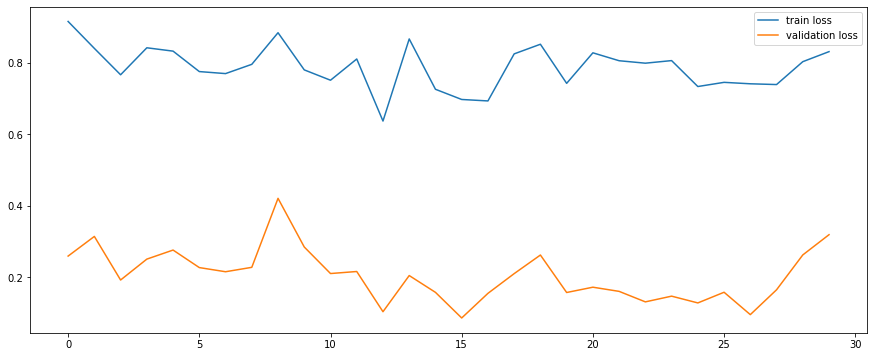

In [18]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

In [29]:
model = lstm()
model.load_state_dict(torch.load('lstm_gas.pt'))
model.eval()
with torch.no_grad():
    preds = []
    labels = []
    for idx, (data, label) in enumerate(test_loader):   
        pred = np.array(model(data.float()))
        label = np.array(label.float())
        for i in range(len(pred)):
            preds.append(pred[i]*std_fory + mean_fory)
            labels.append(label[i]*std_fory + mean_fory)

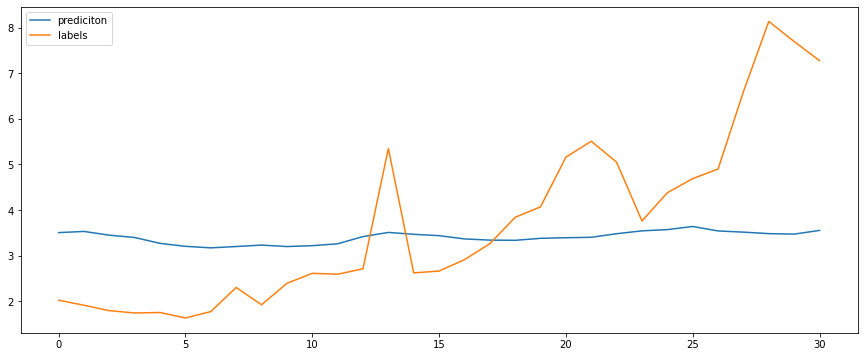

In [30]:
plt.figure(figsize=(15,6))
plt.plot(np.array(preds), label='prediciton')
plt.plot(np.array(labels), label='labels')
plt.legend()